# 线性回归的从零开始实现

我们将从零开始实现整个方法，
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [40]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

- torch.normal()  
  是 PyTorch 中的一个函数，用于从给定参数的离散正态分布中抽取随机数。它有三个参数：means、std 和 out。其中，means 是一个张量，包含每个输出元素相关的正态分布的均值；std 是一个张量，包含每个输出元素相关的正态分布的标准差；而 out 则是一个张量，用于存储结果。如果没有指定 out，则会新建一个张量来存储结果。
- torch.matmul()  
  torch.matmul() 是 PyTorch 中的一个函数，用于计算两个张量的矩阵乘积。它有两个参数：input 和 other。其中，input 和 other 都是张量，且必须满足矩阵乘法的规则
- reshape()  
  torch.reshape() 则是 PyTorch 中的一个函数，用于改变张量的形状。它有两个参数：input 和 shape。其中，input 是一个张量，而 shape 则是一个元组，用于指定新张量的形状  
  reshape((-1, 1)) 是 PyTorch 中的一个函数，用于改变张量的形状。其中，-1 表示该维度的大小由其他维度自动推导得出，而 1 则表示该维度的大小为 1。这个函数通常用于将一个张量转换为列向量。例如，如果一个张量的形状为 (3, 4)，则使用 reshape((-1, 1)) 后，它的形状将变为 (12, 1)

In [41]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，
`labels`中的每一行都包含一维标签值（一个标量）

In [42]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.4616, 0.8709]) 
label: tensor([2.1719])


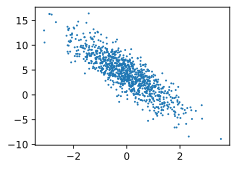

In [43]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

range() 是 Python 中的一个函数，用于生成一个整数序列。它有三个参数：start、stop 和 step。其中，start 表示序列的起始值（默认为 0），stop 表示序列的结束值（不包含在序列中），而 step 表示序列中相邻两个元素之间的差值（默认为 1）

yield 是 Python 中的一个关键字，用于生成器函数中。它的作用是将函数变成一个生成器，每次调用生成器时，会执行到 yield 关键字处，返回一个值，然后暂停函数执行，等待下一次调用

In [44]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            # 使用 min 防止最后一个批次的索引超出边界
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

# 通过 for 循环遍历所有的 yield
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.5727,  0.3486],
        [-0.1994,  1.1469],
        [ 1.1232, -2.9004],
        [ 0.4284, -1.5563],
        [ 0.5660,  0.4436],
        [-0.8542, -0.2012],
        [-0.9856,  0.2675],
        [ 2.5568,  0.5237],
        [-0.5169, -0.1811],
        [ 1.1582,  1.6788]]) 
 tensor([[ 4.1628],
        [-0.0929],
        [16.2943],
        [10.3528],
        [ 3.8356],
        [ 3.1934],
        [ 1.3326],
        [ 7.5601],
        [ 3.7774],
        [ 0.8012]])


在我们开始用小批量随机梯度下降优化我们的模型参数之前
我们需要先有一些参数

In [45]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0099],
         [-0.0076]], requires_grad=True),
 tensor([0.], requires_grad=True))

定义模型，将模型的输入和参数同模型的输出关联起来

In [46]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [47]:
def squared_loss(y_hat, y):  
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [48]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

- backward()  
  在 PyTorch 中，backward() 方法是用于计算张量的梯度的。它属于 torch.autograd 函数库，用于反向传播计算梯度。这个函数只有标量才能直接使用，如果使用自定义的函数，得到的不是标量，则 backward() 时需要传入 grad_variable 参数。使用 backward() 函数反向传播计算张量的梯度时，并不计算所有张量的梯度，而是只计算满足这几个条件的张量的梯度：1. 类型为叶子节点、2. requires_grad=True、3. 依赖该张量的所有张量的 requires_grad=True


In [49]:
lr = 0.03
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039860
epoch 2, loss 0.000147
epoch 3, loss 0.000048
epoch 4, loss 0.000048
epoch 5, loss 0.000048
epoch 6, loss 0.000048
epoch 7, loss 0.000048
epoch 8, loss 0.000048
epoch 9, loss 0.000048
epoch 10, loss 0.000048


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [50]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0004, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([-9.6798e-05], grad_fn=<RsubBackward1>)
